In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import japanize_matplotlib
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")
sample = pd.read_csv('sample_submission.csv')

# ゴールの確認

In [3]:
sample.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


# データの確認

In [4]:
train.sample(10)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
38732,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3686,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30090,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31205,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11331,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22883,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26503,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27313,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35521,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## データの可視化

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

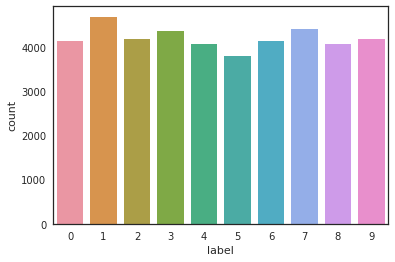

In [5]:
y_train = train['label']

X_train = train.drop(labels=['label'], axis=1)

del train
g = sns.countplot(y_train)
y_train.value_counts()

## 欠損値の確認

In [6]:
y_train.isnull().sum()

0

In [7]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [8]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

# 前処理
- 各要素の正規化
- 1次元のベクトルを2次元に変換
- ラベルをone hotベクトルにする

In [9]:
# 0~255を0~1に正規化
X_train = X_train / 255.0
test = test / 255.0

# 1*784 -> 28*28に変換(1次元を2次元に変換)
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

# ラベルをone hotベクトルに
y_train = to_categorical(y_train, num_classes=10)

# seedを2に設定
random_seed = 2

# trainingデータを分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=random_seed)

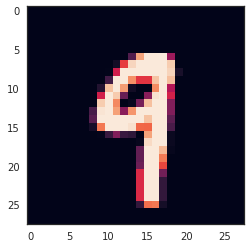

In [10]:
g = plt.imshow(X_train[2][:, :, 0])

# モデル作成

In [11]:
# 入力->畳み込み(Conv2D)->活性化(relu)->プーリング(MaxPool2D)->正則化(Dropout)->一時限に直す(Flatten)->全結合(Dense)->出力
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

# 最適化・損失関数の設定

In [12]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 1
batch_size = 86

# 過学習を抑える設定
- 少し回転させる
- 少し大きくする
- 少し位置を動かす

In [13]:
datagen = ImageDataGenerator(
                featurewise_center=False,
                samplewise_center=False,
                featurewise_std_normalization=False,
                samplewise_std_normalization=False,
                zca_whitening=False,
                rotation_range=10,
                zoom_range=0.1,
                width_shift_range=0.1,
                height_shift_range=0.1,
                horizontal_flip=False,
                vertical_flip=False)

datagen.fit(X_train)

# 学習

In [15]:
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/1
 - 306s - loss: 0.3984 - acc: 0.8708 - val_loss: 0.0796 - val_acc: 0.9762


# 性能評価

In [16]:
results = model.predict(test)

results = np.argmax(results, axis=1)
results = pd.Series(results, name='Label')

submission = pd.concat([pd.Series(range(1, 28001), name='ImageId'), results], axis=1)
submission.to_csv('cnn_mnist_datagen.csv', index=False)